# Clasificación de Dígitos Manuscritos Europeos.
## Aprendizaje de Máquinas Supervisado - Inteligencia Artificial 2025-I

---

## 1. Descripción del Problema

### 1.1 Contexto del Problema
El reconocimiento de dígitos manuscritos es un problema fundamental en el campo de la visión por computadora y el aprendizaje automático. Mientras que el conjunto de datos MNIST (Modified National Institute of Standards and Technology / Instituto de Estándares y Tecnología de los Estados Unidos)[1] se ha convertido en el estándar de facto para esta tarea, presenta una limitación importante: contiene únicamente dígitos escritos en notación americana, lo que dificulta la clasificación de números aislados, especialmente los dígitos 1 y 7.

Este proyecto aborda la clasificación de dígitos manuscritos europeos (específicamente suizos), donde existen diferencias notables en la forma de escribir ciertos números. Por ejemplo, el dígito 1 europeo típicamente incluye una línea diagonal en la parte superior, y el 7 europeo frecuentemente tiene una línea horizontal que lo cruza, características que pueden crear confusión con otros dígitos. El dataset utilizado para cumplir este propósito se encuentra disponible en https://www.kaggle.com/datasets/olafkrastovski/handwritten-digits-0-9/data (André Meier, autor)[2].


### 1.2 Conjunto de Datos
El conjunto de datos utilizado contiene aproximadamente 21,600 imágenes de dígitos manuscritos del 0 al 9, escritos en notación europea (suiza). Las características principales del dataset son:
- **Formato de imágenes**: Archivos .jpg a color
- **Dimensiones**: 90x140 píxeles
- **Número de clases**: 10 (dígitos 0-9)
- **Distribución**: Aproximadamente 2,160 imágenes por clase
- **Particularidad**: Posible presencia de pequeños bordes negros en algunas imágenes

---

## 2. Importación de Librerías y Carga de Datos

In [1]:
# Importación de librerías necesarias
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Librerías para machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report,
                           confusion_matrix, precision_score, recall_score, f1_score)

## 3. Inspección y Análisis Exploratorio de Datos

### 3.1 Carga y Exploración Inicial

In [2]:
# Configuración de visualización
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_palette("husl")

print("Librerías importadas exitosamente")

DATA_PATH = "archive"
print(f"Ruta del dataset: {DATA_PATH}")

if os.path.exists(DATA_PATH):
    folders = sorted([f for f in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, f))])
    print(f"Carpetas encontradas: {folders}")
    print(f"Número de clases: {len(folders)}")
else:
    print("ERROR: No se encontró la carpeta del dataset. Verifica la ruta.")

def load_dataset_info(data_path):
    """
    Función para cargar información básica del dataset
    """
    dataset_info = {}

    for digit in range(10):
        digit_path = os.path.join(data_path, str(digit))
        if os.path.exists(digit_path):
            images = [f for f in os.listdir(digit_path) if f.endswith('.jpg')]
            dataset_info[digit] = {
                'count': len(images),
                'sample_files': images[:5]  # Primeras 5 imágenes como muestra
            }

    return dataset_info

# Cargar información del dataset
dataset_info = load_dataset_info(DATA_PATH)

# Mostrar información del dataset
print("\n" + "="*50)
print("INFORMACIÓN DEL DATASET")
print("="*50)

total_images = 0
for digit, info in dataset_info.items():
    print(f"Dígito {digit}: {info['count']} imágenes")
    total_images += info['count']

print(f"\nTotal de imágenes: {total_images}")
print(f"Promedio por clase: {total_images/10:.1f}")

def load_and_analyze_image(digit, image_index=0):
    """
    Cargar una imagen específica y analizar sus propiedades
    """
    digit_path = os.path.join(DATA_PATH, str(digit))
    images = [f for f in os.listdir(digit_path) if f.endswith('.jpg')]

    if image_index < len(images):
        image_path = os.path.join(digit_path, images[image_index])

        # Cargar con PIL
        pil_image = Image.open(image_path)

        # Cargar con OpenCV
        cv_image = cv2.imread(image_path)
        cv_image_rgb = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)

        return {
            'path': image_path,
            'filename': images[image_index],
            'pil_image': pil_image,
            'cv_image': cv_image_rgb,
            'shape': cv_image_rgb.shape,
            'size': pil_image.size,
            'mode': pil_image.mode
        }
    else:
        return None

# Analizar una imagen de muestra de cada dígito
print("\n" + "="*50)
print("ANÁLISIS DE IMÁGENES DE MUESTRA")
print("="*50)

sample_images = {}
for digit in range(10):
    sample = load_and_analyze_image(digit, 0)
    if sample:
        sample_images[digit] = sample
        print(f"Dígito {digit}:")
        print(f"  - Archivo: {sample['filename']}")
        print(f"  - Dimensiones: {sample['shape']} (altura x ancho x canales)")
        print(f"  - Tamaño: {sample['size']} píxeles")
        print(f"  - Modo de color: {sample['mode']}")

# Verificar consistencia en las dimensiones
shapes = [sample['shape'] for sample in sample_images.values()]
unique_shapes = list(set(shapes))
print(f"\nDimensiones únicas encontradas: {unique_shapes}")

if len(unique_shapes) == 1:
    print("✓ Todas las imágenes tienen las mismas dimensiones")
else:
    print("Las imágenes tienen dimensiones diferentes")

print("\n" + "="*50)
print("CARGA INICIAL COMPLETADA")
print("="*50)

Librerías importadas exitosamente
Ruta del dataset: archive
Carpetas encontradas: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Número de clases: 10

INFORMACIÓN DEL DATASET
Dígito 0: 2236 imágenes
Dígito 1: 2241 imágenes
Dígito 2: 2233 imágenes
Dígito 3: 2202 imágenes
Dígito 4: 2179 imágenes
Dígito 5: 2126 imágenes
Dígito 6: 2121 imágenes
Dígito 7: 2116 imágenes
Dígito 8: 2085 imágenes
Dígito 9: 2016 imágenes

Total de imágenes: 21555
Promedio por clase: 2155.5

ANÁLISIS DE IMÁGENES DE MUESTRA
Dígito 0:
  - Archivo: Zero_full (1).jpg
  - Dimensiones: (140, 90, 3) (altura x ancho x canales)
  - Tamaño: (90, 140) píxeles
  - Modo de color: RGB
Dígito 1:
  - Archivo: One_full (1).jpg
  - Dimensiones: (140, 90, 3) (altura x ancho x canales)
  - Tamaño: (90, 140) píxeles
  - Modo de color: RGB
Dígito 2:
  - Archivo: Two_full (1).jpg
  - Dimensiones: (140, 90, 3) (altura x ancho x canales)
  - Tamaño: (90, 140) píxeles
  - Modo de color: RGB
Dígito 3:
  - Archivo: Three_full (1).jpg
  

### 3.2 Distribución de Clases

Distribución de clases:
   Dígito  Cantidad  Porcentaje
0       0      2236   10.373463
1       1      2241   10.396660
2       2      2233   10.359545
3       3      2202   10.215727
4       4      2179   10.109023
5       5      2126    9.863141
6       6      2121    9.839944
7       7      2116    9.816748
8       8      2085    9.672930
9       9      2016    9.352818


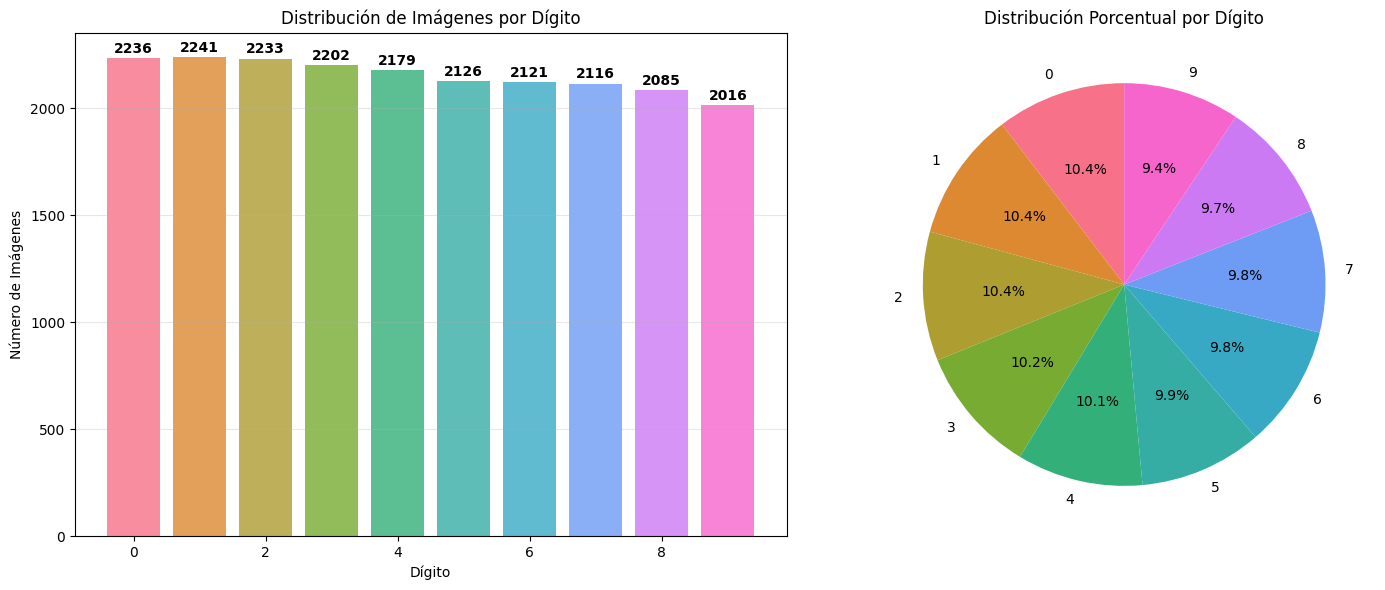


ANÁLISIS DE DISTRIBUCIÓN
Desviación estándar de la distribución: 75.0
Coeficiente de variación: 3.5%
Clase con menos imágenes: Dígito 9.0 (2016.0 imágenes)
Clase con más imágenes: Dígito 1.0 (2241.0 imágenes)
Diferencia entre max y min: 225.0 imágenes


In [3]:
# Crear un DataFrame con la información de distribución
distribution_data = []
for digit, info in dataset_info.items():
    distribution_data.append({
        'Dígito': digit,
        'Cantidad': info['count'],
        'Porcentaje': (info['count'] / total_images) * 100
    })

df_distribution = pd.DataFrame(distribution_data)
print("Distribución de clases:")
print(df_distribution)

# Visualización de la distribución de clases
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de barras
bars = ax1.bar(df_distribution['Dígito'], df_distribution['Cantidad'],
               color=sns.color_palette("husl", 10), alpha=0.8)
ax1.set_xlabel('Dígito')
ax1.set_ylabel('Número de Imágenes')
ax1.set_title('Distribución de Imágenes por Dígito')
ax1.grid(axis='y', alpha=0.3)

# Agregar valores encima de las barras
for bar, count in zip(bars, df_distribution['Cantidad']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
             str(count), ha='center', va='bottom', fontweight='bold')

# Gráfico de pastel
wedges, texts, autotexts = ax2.pie(df_distribution['Cantidad'],
                                   labels=df_distribution['Dígito'],
                                   autopct='%1.1f%%', startangle=90,
                                   colors=sns.color_palette("husl", 10))
ax2.set_title('Distribución Porcentual por Dígito')

plt.tight_layout()
plt.show()

# Análisis de la distribución
print("\n" + "="*50)
print("ANÁLISIS DE DISTRIBUCIÓN")
print("="*50)
print(f"Desviación estándar de la distribución: {df_distribution['Cantidad'].std():.1f}")
print(f"Coeficiente de variación: {(df_distribution['Cantidad'].std() / df_distribution['Cantidad'].mean())*100:.1f}%")

min_class = df_distribution.loc[df_distribution['Cantidad'].idxmin()]
max_class = df_distribution.loc[df_distribution['Cantidad'].idxmax()]
print(f"Clase con menos imágenes: Dígito {min_class['Dígito']} ({min_class['Cantidad']} imágenes)")
print(f"Clase con más imágenes: Dígito {max_class['Dígito']} ({max_class['Cantidad']} imágenes)")
print(f"Diferencia entre max y min: {max_class['Cantidad'] - min_class['Cantidad']} imágenes")

### 3.3 Visualización de Muestras Representativas

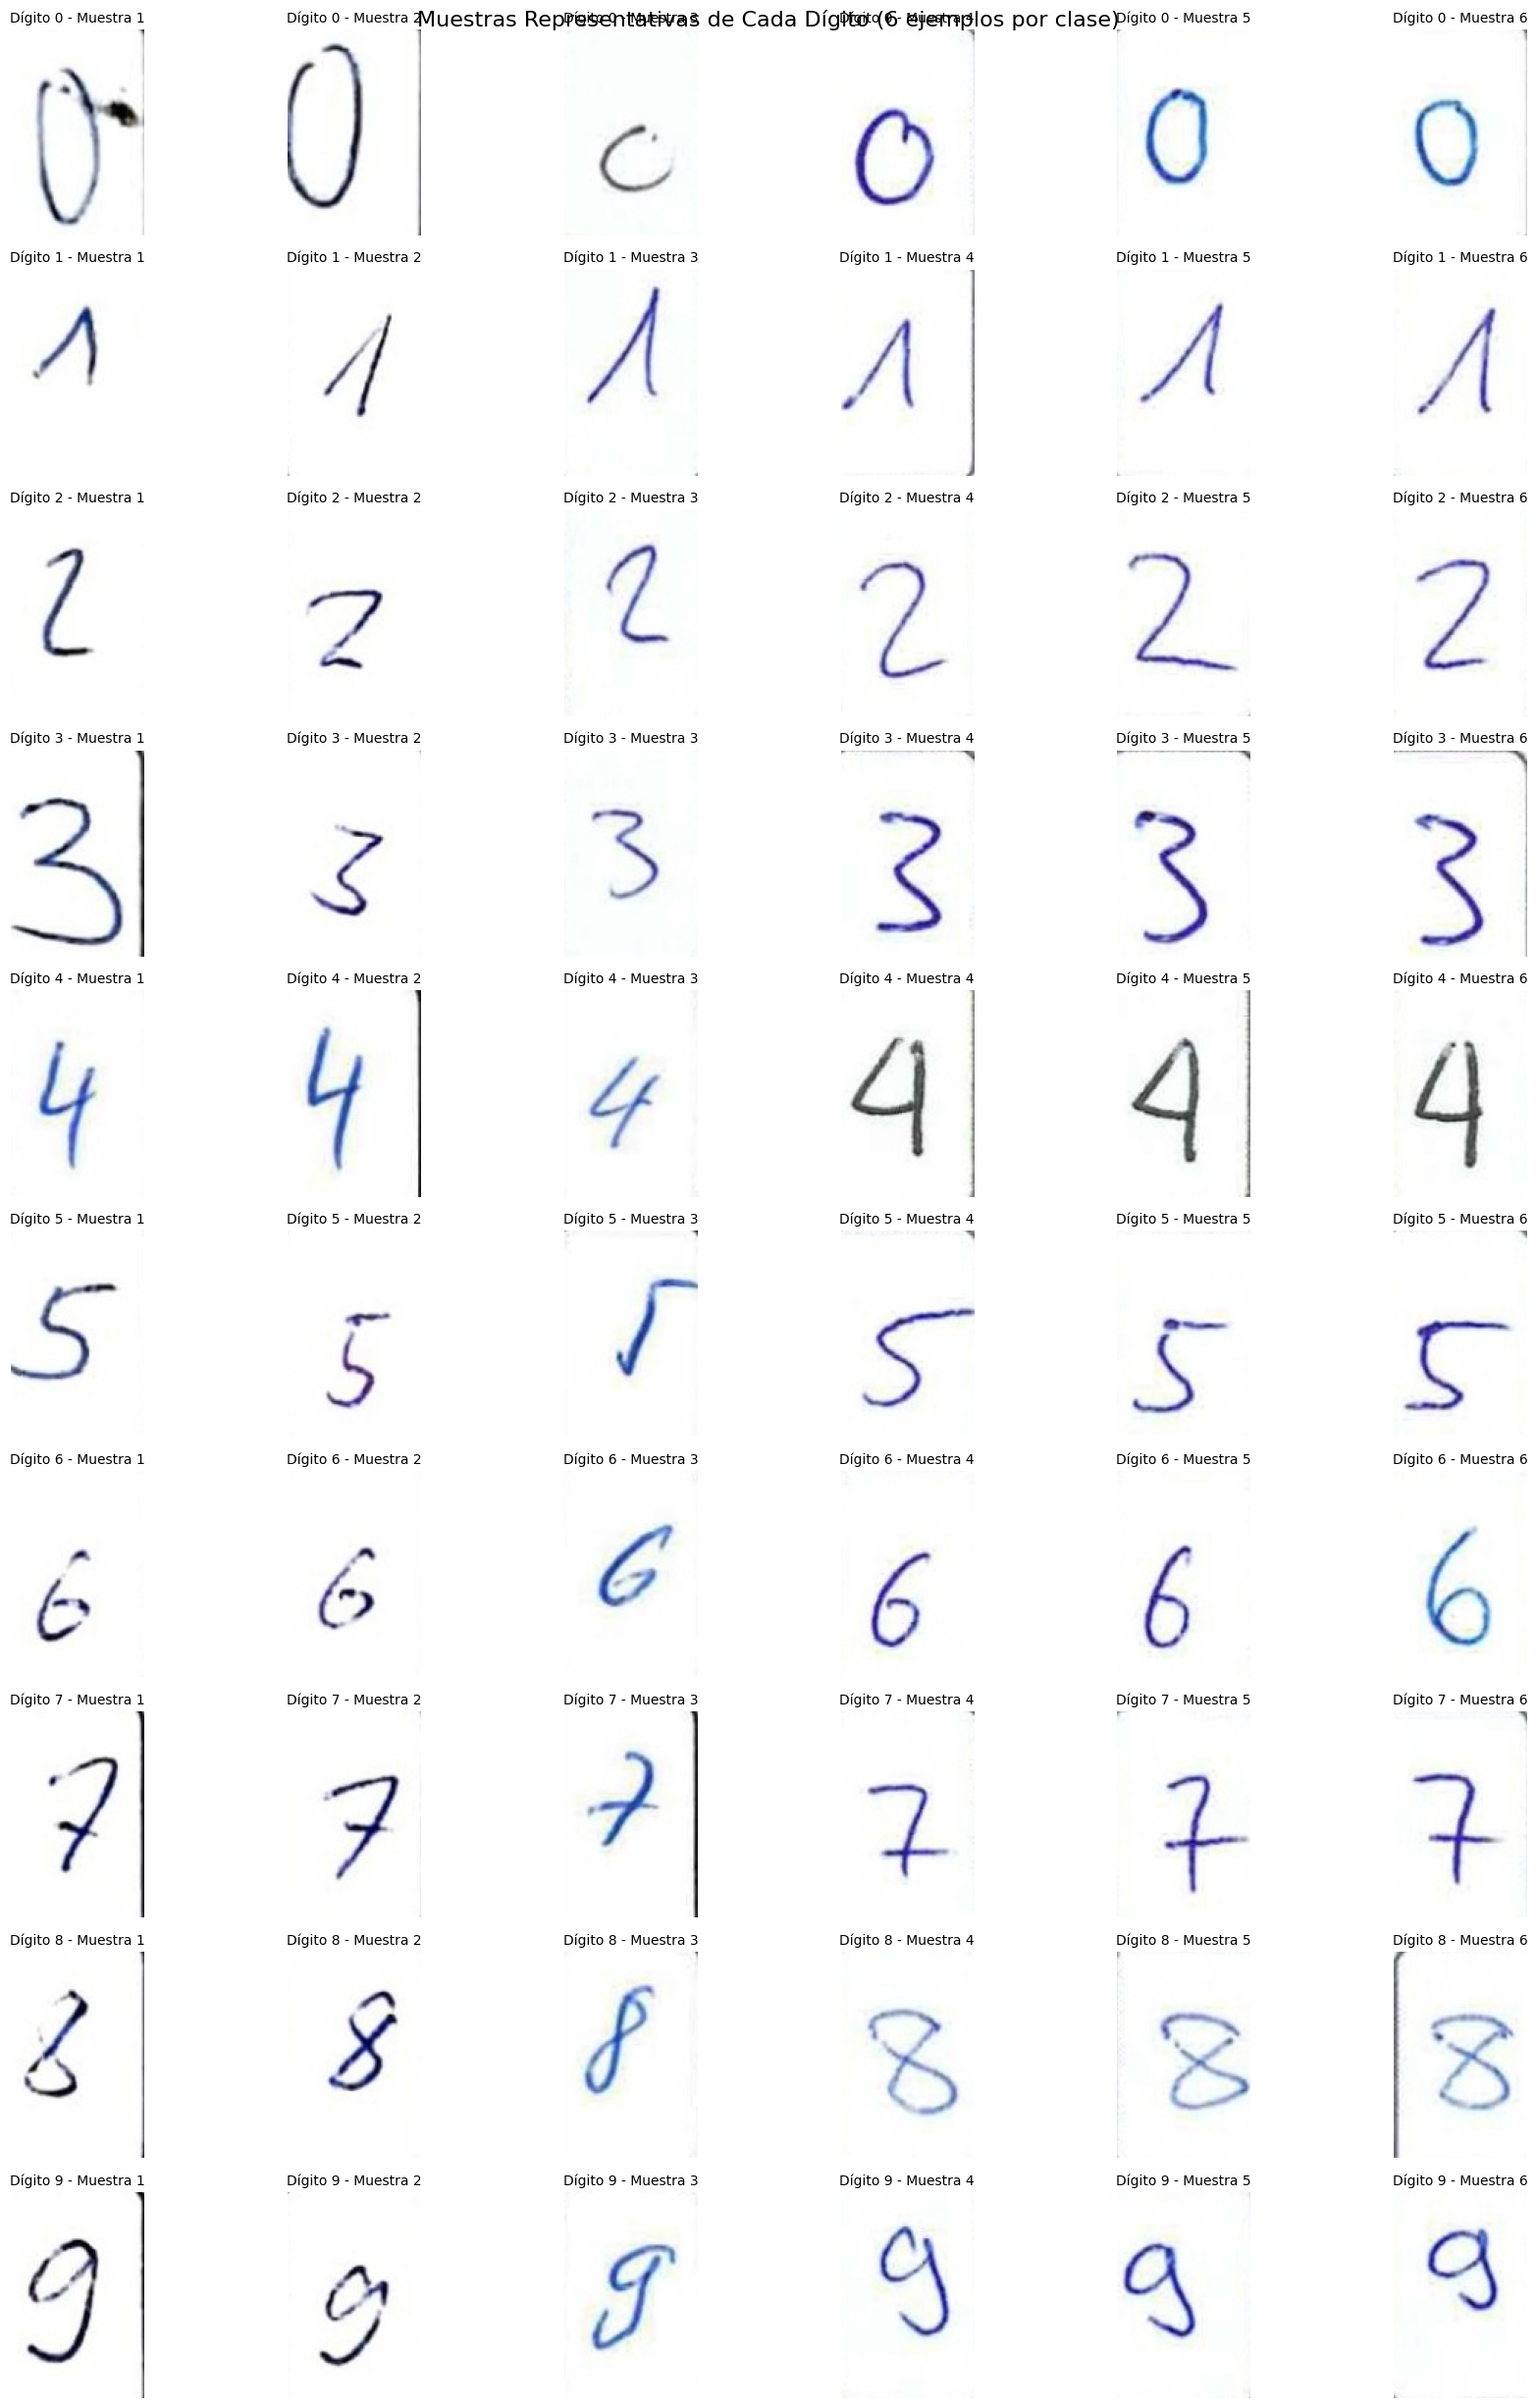

In [4]:
# Función para cargar múltiples imágenes de una clase
def load_multiple_images(digit, num_images=6):
    digit_path = os.path.join(DATA_PATH, str(digit))
    images = [f for f in os.listdir(digit_path) if f.endswith('.jpg')]

    loaded_images = []
    for i in range(min(num_images, len(images))):
        image_path = os.path.join(digit_path, images[i])
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        loaded_images.append(image_rgb)

    return loaded_images

# Mostrar muestras de cada dígito
fig, axes = plt.subplots(10, 6, figsize=(18, 25))
fig.suptitle('Muestras Representativas de Cada Dígito (6 ejemplos por clase)', fontsize=16, y=0.98)

for digit in range(10):
    images = load_multiple_images(digit, 6)
    for i, img in enumerate(images):
        axes[digit, i].imshow(img)
        axes[digit, i].set_title(f'Dígito {digit} - Muestra {i+1}', fontsize=10)
        axes[digit, i].axis('off')

    # Si hay menos de 6 imágenes, ocultar los ejes sobrantes
    for j in range(len(images), 6):
        axes[digit, j].axis('off')

plt.tight_layout()
plt.show()

### 3.3 Análisis de Características Visuales


ANÁLISIS DETALLADO DE DÍGITOS 1 Y 7


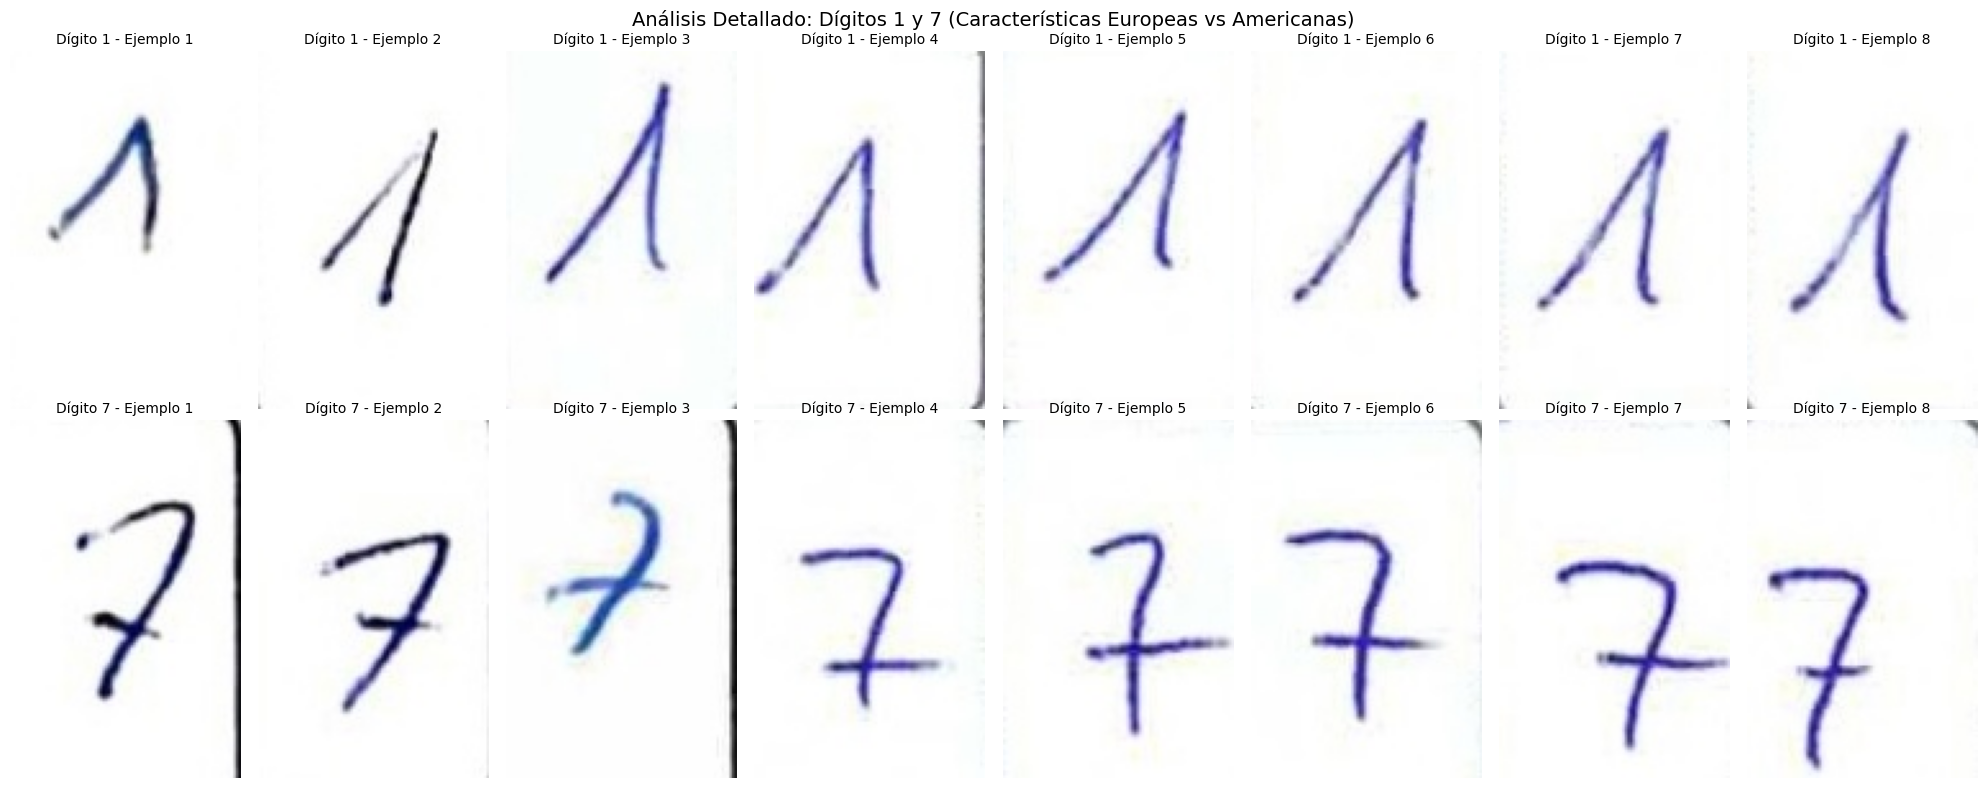

In [5]:
# Análisis específico de los dígitos problemáticos (1 y 7)
print("\n" + "="*50)
print("ANÁLISIS DETALLADO DE DÍGITOS 1 Y 7")
print("="*50)

fig, axes = plt.subplots(2, 8, figsize=(20, 8))
fig.suptitle('Análisis Detallado: Dígitos 1 y 7 (Características Europeas vs Americanas)', fontsize=14)

# Cargar 8 ejemplos del dígito 1
images_1 = load_multiple_images(1, 8)
for i, img in enumerate(images_1):
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Dígito 1 - Ejemplo {i+1}', fontsize=10)
    axes[0, i].axis('off')

# Cargar 8 ejemplos del dígito 7
images_7 = load_multiple_images(7, 8)
for i, img in enumerate(images_7):
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Dígito 7 - Ejemplo {i+1}', fontsize=10)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Observaciones sobre las características europeas:
- Dígito 1: Se puede observar la línea diagonal característica en la parte superior
- Dígito 7: Algunos ejemplos muestran la línea horizontal que cruza el dígito

### 3.4 Análisis de Propiedades de las Imágenes


ANÁLISIS DE PROPIEDADES DE IMÁGENES
Propiedades estadísticas por dígito:
   Dígito  Brillo Promedio  Desv. Est. Brillo  Intensidad Media  \
0       0           244.48              28.59            244.48   
1       1           245.39              32.29            245.39   
2       2           243.72              34.22            243.72   
3       3           244.20              29.92            244.20   
4       4           242.04              38.09            242.04   
5       5           244.33              30.52            244.33   
6       6           244.95              29.27            244.95   
7       7           245.23              29.48            245.23   
8       8           242.36              32.65            242.36   
9       9           237.30              37.09            237.30   

   Desv. Est. Intensidad  
0                  30.05  
1                  33.17  
2                  35.31  
3                  31.40  
4                  38.84  
5                  31.06  

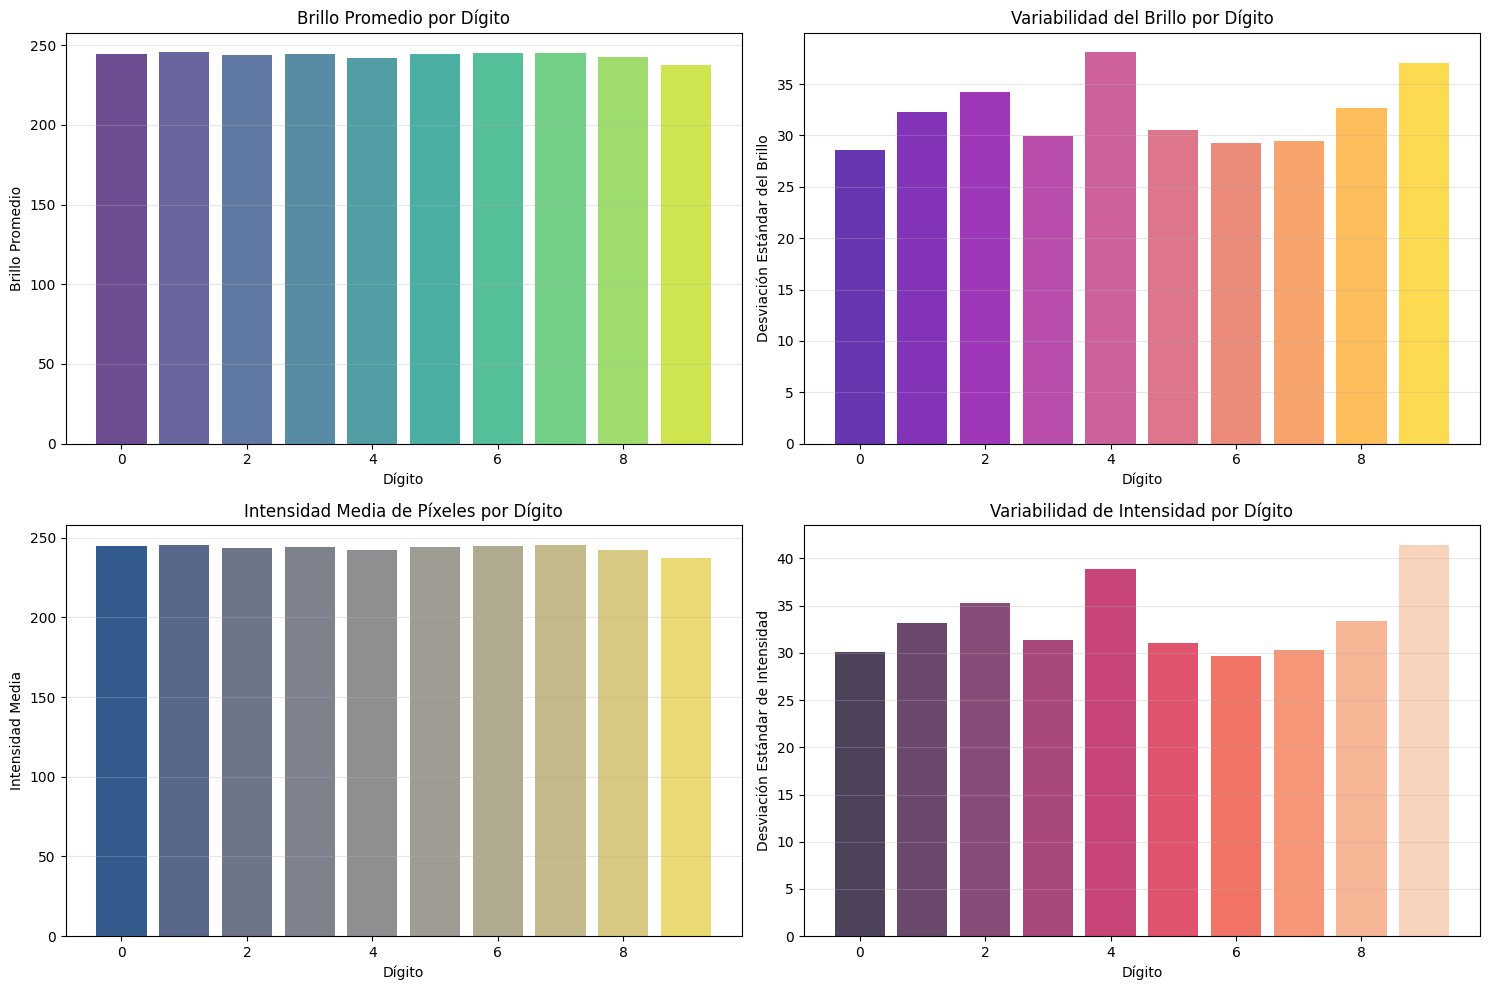

In [6]:
# Análisis de intensidad de píxeles
def analyze_image_properties(digit, num_samples=50):
    """
    Analizar propiedades estadísticas de las imágenes
    """
    digit_path = os.path.join(DATA_PATH, str(digit))
    images = [f for f in os.listdir(digit_path) if f.endswith('.jpg')]

    intensities = []
    means = []
    stds = []

    for i in range(min(num_samples, len(images))):
        image_path = os.path.join(digit_path, images[i])
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Convertir a escala de grises para análisis
        gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

        intensities.extend(gray.flatten())
        means.append(np.mean(gray))
        stds.append(np.std(gray))

    return {
        'intensities': intensities,
        'mean_brightness': np.mean(means),
        'std_brightness': np.mean(stds),
        'overall_mean': np.mean(intensities),
        'overall_std': np.std(intensities)
    }

# Analizar propiedades para cada dígito
print("\n" + "="*50)
print("ANÁLISIS DE PROPIEDADES DE IMÁGENES")
print("="*50)

properties_data = []
for digit in range(10):
    props = analyze_image_properties(digit)
    properties_data.append({
        'Dígito': digit,
        'Brillo Promedio': props['mean_brightness'],
        'Desv. Est. Brillo': props['std_brightness'],
        'Intensidad Media': props['overall_mean'],
        'Desv. Est. Intensidad': props['overall_std']
    })

df_properties = pd.DataFrame(properties_data)
print("Propiedades estadísticas por dígito:")
print(df_properties.round(2))

# Visualización de propiedades
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Brillo promedio por dígito
ax1.bar(df_properties['Dígito'], df_properties['Brillo Promedio'],
        color=sns.color_palette("viridis", 10), alpha=0.8)
ax1.set_xlabel('Dígito')
ax1.set_ylabel('Brillo Promedio')
ax1.set_title('Brillo Promedio por Dígito')
ax1.grid(axis='y', alpha=0.3)

# Desviación estándar del brillo
ax2.bar(df_properties['Dígito'], df_properties['Desv. Est. Brillo'],
        color=sns.color_palette("plasma", 10), alpha=0.8)
ax2.set_xlabel('Dígito')
ax2.set_ylabel('Desviación Estándar del Brillo')
ax2.set_title('Variabilidad del Brillo por Dígito')
ax2.grid(axis='y', alpha=0.3)

# Intensidad media por dígito
ax3.bar(df_properties['Dígito'], df_properties['Intensidad Media'],
        color=sns.color_palette("cividis", 10), alpha=0.8)
ax3.set_xlabel('Dígito')
ax3.set_ylabel('Intensidad Media')
ax3.set_title('Intensidad Media de Píxeles por Dígito')
ax3.grid(axis='y', alpha=0.3)

# Desviación estándar de intensidad
ax4.bar(df_properties['Dígito'], df_properties['Desv. Est. Intensidad'],
        color=sns.color_palette("rocket", 10), alpha=0.8)
ax4.set_xlabel('Dígito')
ax4.set_ylabel('Desviación Estándar de Intensidad')
ax4.set_title('Variabilidad de Intensidad por Dígito')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 3.5 Detección de Bordes Negros


ANÁLISIS DE BORDES NEGROS
Análisis de bordes negros por dígito:
   Dígito  Imágenes con bordes  Total analizado  Porcentaje
0       0                    0               20         0.0
1       1                    0               20         0.0
2       2                    0               20         0.0
3       3                    0               20         0.0
4       4                    1               20         5.0
5       5                    0               20         0.0
6       6                    0               20         0.0
7       7                    2               20        10.0
8       8                    0               20         0.0
9       9                    0               20         0.0


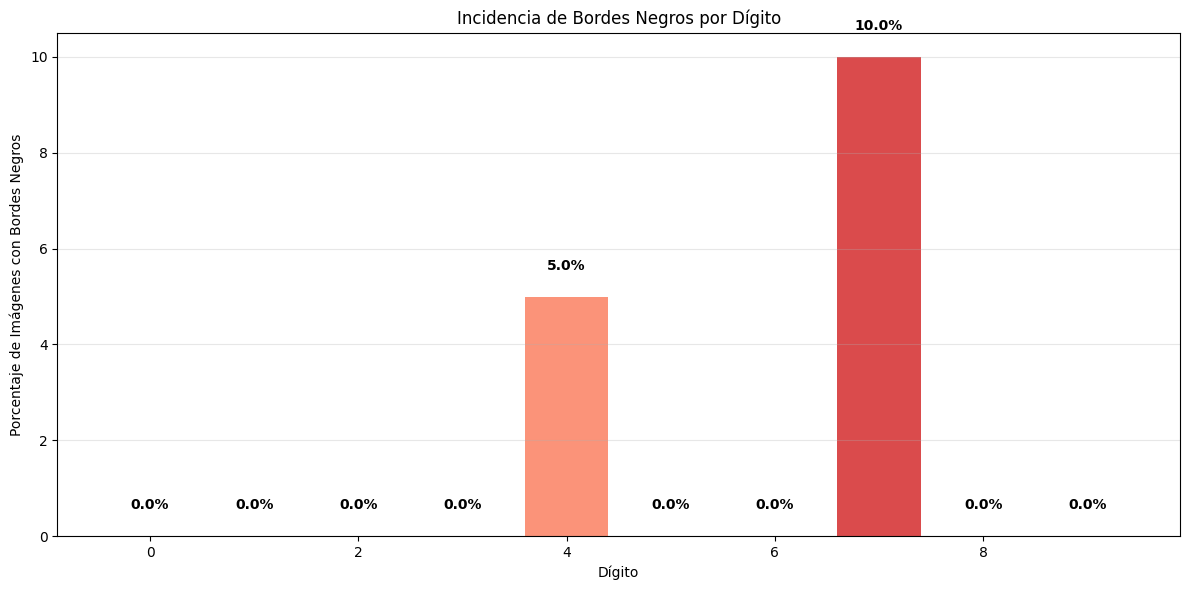


ANÁLISIS EXPLORATORIO COMPLETADO


In [7]:
def detect_black_borders(digit, num_samples=10):
    digit_path = os.path.join(DATA_PATH, str(digit))
    images = [f for f in os.listdir(digit_path) if f.endswith('.jpg')]

    border_info = []

    for i in range(min(num_samples, len(images))):
        image_path = os.path.join(digit_path, images[i])
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Verificar bordes (primeras y últimas filas/columnas)
        top_border = np.mean(image_rgb[0, :, :])
        bottom_border = np.mean(image_rgb[-1, :, :])
        left_border = np.mean(image_rgb[:, 0, :])
        right_border = np.mean(image_rgb[:, -1, :])

        # Considerar como borde negro si el promedio es menor a 30
        has_border = any([top_border < 30, bottom_border < 30,
                         left_border < 30, right_border < 30])

        border_info.append({
            'filename': images[i],
            'has_border': has_border,
            'top': top_border,
            'bottom': bottom_border,
            'left': left_border,
            'right': right_border
        })

    return border_info

# Analizar bordes negros
print("\n" + "="*50)
print("ANÁLISIS DE BORDES NEGROS")
print("="*50)

border_stats = []
for digit in range(10):
    border_info = detect_black_borders(digit, 20)
    images_with_borders = sum([1 for info in border_info if info['has_border']])
    percentage_with_borders = (images_with_borders / len(border_info)) * 100

    border_stats.append({
        'Dígito': digit,
        'Imágenes con bordes': images_with_borders,
        'Total analizado': len(border_info),
        'Porcentaje': percentage_with_borders
    })

df_borders = pd.DataFrame(border_stats)
print("Análisis de bordes negros por dígito:")
print(df_borders)

# Visualización de bordes negros
plt.figure(figsize=(12, 6))
bars = plt.bar(df_borders['Dígito'], df_borders['Porcentaje'],
               color=sns.color_palette("Reds", 10), alpha=0.8)
plt.xlabel('Dígito')
plt.ylabel('Porcentaje de Imágenes con Bordes Negros')
plt.title('Incidencia de Bordes Negros por Dígito')
plt.grid(axis='y', alpha=0.3)

# Agregar valores encima de las barras
for bar, percentage in zip(bars, df_borders['Porcentaje']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{percentage:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("ANÁLISIS EXPLORATORIO COMPLETADO")
print("="*50)

---

## 4. Preprocesamiento de Datos

### 4.1 Estrategias de Preprocesamiento
Basándonos en el análisis exploratorio realizado, se han identificado las siguientes necesidades de preprocesamiento:

1. **Conversión a escala de grises**: Reducir la dimensionalidad y enfocar en patrones estructurales
2. **Normalización de píxeles**: Estandarizar valores entre 0 y 1 para mejorar convergencia
3. **Manejo de bordes negros**: Recorte o padding para los casos identificados (5-10% de imágenes)
4. **Redimensionamiento consistente**: Asegurar dimensiones uniformes
5. **Aplanamiento de datos**: Convertir matrices 2D a vectores 1D para algoritmos clásicos
6. **División estratificada**: Mantener la proporción de clases en train/test

### 4.2 Implementación del preprocesamiento.

In [35]:
# Función principal para cargar y preprocesar todo el dataset
def load_and_preprocess_dataset(data_path, img_size=(28, 28), test_size=0.2, random_state=42):
    """
    Cargar y preprocesar todo el dataset

    Parameters:
    - data_path: ruta al dataset
    - img_size: tamaño final de las imágenes (altura, ancho)
    - test_size: proporción para conjunto de prueba
    - random_state: semilla para reproducibilidad
    """

    print("Iniciando carga y preprocesamiento del dataset...")

    # Listas para almacenar datos y etiquetas
    X = []  # Imágenes
    y = []  # Etiquetas

    # Contadores para tracking
    processed_count = 0
    border_removed_count = 0

    # Cargar imágenes de cada clase
    for digit in range(10):
        digit_path = os.path.join(data_path, str(digit))
        image_files = [f for f in os.listdir(digit_path) if f.endswith('.jpg')]

        print(f"Procesando dígito {digit}: {len(image_files)} imágenes")

        for filename in image_files:
            image_path = os.path.join(digit_path, filename)

            # Cargar imagen
            image = cv2.imread(image_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Preprocesamiento
            processed_image = preprocess_single_image(image_rgb, img_size)

            # Verificar si se removieron bordes
            if has_black_borders(image_rgb):
                border_removed_count += 1

            X.append(processed_image)
            y.append(digit)
            processed_count += 1

    print(f"\nProcesamiento completado:")
    print(f"- Total de imágenes procesadas: {processed_count}")
    print(f"- Imágenes con bordes removidos: {border_removed_count}")

    # Convertir a arrays numpy
    X = np.array(X)
    y = np.array(y)

    print(f"- Forma final de X: {X.shape}")
    print(f"- Forma final de y: {y.shape}")

    return X, y

def preprocess_single_image(image, target_size=(28, 28)):
    """
    Preprocesar una sola imagen
    """
    # 1. Detectar y remover bordes negros si existen
    image_clean = remove_black_borders(image)

    # 2. Convertir a escala de grises
    gray = cv2.cvtColor(image_clean, cv2.COLOR_RGB2GRAY)

    # 3. Redimensionar
    resized = cv2.resize(gray, target_size, interpolation=cv2.INTER_AREA)

    # 4. Normalizar píxeles (0-255 -> 0-1)
    normalized = resized.astype(np.float32) / 255.0

    return normalized

def has_black_borders(image, threshold=30):
    """
    Detectar si una imagen tiene bordes negros
    """
    h, w = image.shape[:2]

    # Verificar bordes
    top_border = np.mean(image[0, :, :])
    bottom_border = np.mean(image[h-1, :, :])
    left_border = np.mean(image[:, 0, :])
    right_border = np.mean(image[:, w-1, :])

    return any([top_border < threshold, bottom_border < threshold,
                left_border < threshold, right_border < threshold])

def remove_black_borders(image, threshold=30):
    """
    Remover bordes negros de una imagen
    """
    if not has_black_borders(image, threshold):
        return image

    # Convertir a escala de grises para análisis
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Encontrar contornos del contenido no negro
    _, binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)

    # Encontrar coordenadas del contenido
    coords = cv2.findNonZero(binary)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)

        # Agregar un pequeño padding si es posible
        padding = 2
        x = max(0, x - padding)
        y = max(0, y - padding)
        w = min(image.shape[1] - x, w + 2*padding)
        h = min(image.shape[0] - y, h + 2*padding)

        # Recortar imagen
        cropped = image[y:y+h, x:x+w]

        # Verificar que el recorte no sea demasiado pequeño
        if cropped.shape[0] > 10 and cropped.shape[1] > 10:
            return cropped

    # Si no se puede recortar apropiadamente, devolver original
    return image

# Ejecutar preprocesamiento completo
print("="*60)
print("INICIANDO PREPROCESAMIENTO COMPLETO DEL DATASET")
print("="*60)

# Cargar y preprocesar dataset
X_processed, y_processed = load_and_preprocess_dataset(DATA_PATH, img_size=(28, 28))

INICIANDO PREPROCESAMIENTO COMPLETO DEL DATASET
Iniciando carga y preprocesamiento del dataset...
Procesando dígito 0: 2236 imágenes
Procesando dígito 1: 2241 imágenes
Procesando dígito 2: 2233 imágenes
Procesando dígito 3: 2202 imágenes
Procesando dígito 4: 2179 imágenes
Procesando dígito 5: 2126 imágenes
Procesando dígito 6: 2121 imágenes
Procesando dígito 7: 2116 imágenes
Procesando dígito 8: 2085 imágenes
Procesando dígito 9: 2016 imágenes

Procesamiento completado:
- Total de imágenes procesadas: 21555
- Imágenes con bordes removidos: 493
- Forma final de X: (21555, 28, 28)
- Forma final de y: (21555,)


PRUEBA DEL PREPROCESAMIENTO


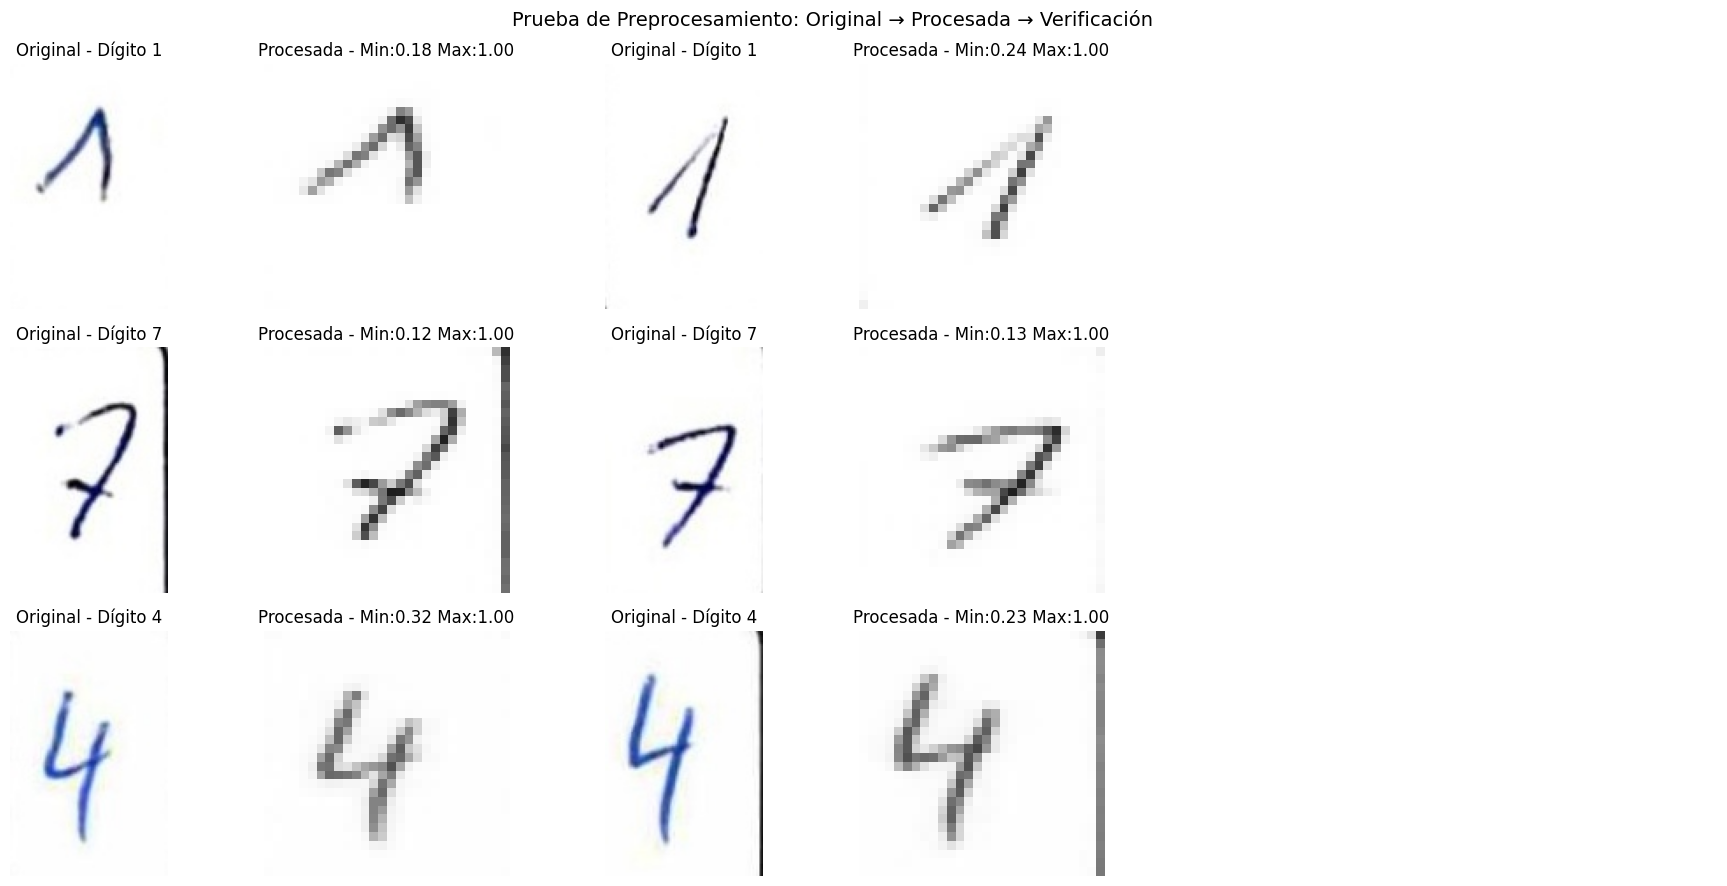

In [36]:
#PRUEBA DE PREPROCESAMIENTO :)
print("="*60)
print("PRUEBA DEL PREPROCESAMIENTO")
print("="*60)

def test_preprocessing():
    """
    Probar el preprocesamiento con algunas imágenes de muestra
    """
    fig, axes = plt.subplots(3, 6, figsize=(18, 9))
    fig.suptitle('Prueba de Preprocesamiento: Original → Procesada → Verificación', fontsize=14)

    test_digits = [1, 7, 4]  # Incluir dígitos problemáticos

    for i, digit in enumerate(test_digits):
        digit_path = os.path.join(DATA_PATH, str(digit))
        image_files = [f for f in os.listdir(digit_path) if f.endswith('.jpg')]

        # Tomar 2 ejemplos de cada dígito
        for j in range(2):
            col_base = j * 2

            # Cargar imagen original
            image_path = os.path.join(digit_path, image_files[j])
            original = cv2.imread(image_path)
            original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

            # Procesar imagen
            processed = preprocess_single_image(original_rgb, target_size=(28, 28))

            # Mostrar original
            axes[i, col_base].imshow(original_rgb)
            axes[i, col_base].set_title(f'Original - Dígito {digit}')
            axes[i, col_base].axis('off')

            # Mostrar procesada
            axes[i, col_base + 1].imshow(processed, cmap='gray', vmin=0, vmax=1)
            axes[i, col_base + 1].set_title(f'Procesada - Min:{processed.min():.2f} Max:{processed.max():.2f}')
            axes[i, col_base + 1].axis('off')

    # Últimas dos columnas para estadísticas
    for i in range(3):
        axes[i, 4].axis('off')
        axes[i, 5].axis('off')

    plt.tight_layout()
    plt.show()

    return True

# Ejecutar prueba
test_result = test_preprocessing()

### 4.3 División del Dataset

In [38]:
# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_processed,
    test_size=0.2,
    random_state=42,
    stratify=y_processed
)

print("\n" + "="*50)
print("DIVISIÓN DEL DATASET")
print("="*50)
print(f"Conjunto de entrenamiento: {X_train.shape[0]} imágenes")
print(f"Conjunto de prueba: {X_test.shape[0]} imágenes")
print(f"Proporción: {X_train.shape[0]/(X_train.shape[0]+X_test.shape[0])*100:.1f}% entrenamiento, {X_test.shape[0]/(X_train.shape[0]+X_test.shape[0])*100:.1f}% prueba")

# Verificar distribución estratificada
train_distribution = pd.Series(y_train).value_counts().sort_index()
test_distribution = pd.Series(y_test).value_counts().sort_index()

print("\nDistribución por clase:")
distribution_df = pd.DataFrame({
    'Dígito': range(10),
    'Entrenamiento': train_distribution.values,
    'Prueba': test_distribution.values,
    'Total': train_distribution.values + test_distribution.values
})
distribution_df['% Entrenamiento'] = (distribution_df['Entrenamiento'] / distribution_df['Total'] * 100).round(1)
print(distribution_df)


DIVISIÓN DEL DATASET
Conjunto de entrenamiento: 17244 imágenes
Conjunto de prueba: 4311 imágenes
Proporción: 80.0% entrenamiento, 20.0% prueba

Distribución por clase:
   Dígito  Entrenamiento  Prueba  Total  % Entrenamiento
0       0           1789     447   2236             80.0
1       1           1793     448   2241             80.0
2       2           1786     447   2233             80.0
3       3           1761     441   2202             80.0
4       4           1743     436   2179             80.0
5       5           1701     425   2126             80.0
6       6           1697     424   2121             80.0
7       7           1693     423   2116             80.0
8       8           1668     417   2085             80.0
9       9           1613     403   2016             80.0


### 4.4 Preparación para Modelos Específicos

In [39]:
# Para modelos que requieren datos aplanados (regresión logística, árboles, random forest)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"\nDatos aplanados para modelos clásicos:")
print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

# Estandarización para modelos que lo requieren (regresión logística, redes neuronales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

print(f"\nDatos estandarizados:")
print(f"Media después de escalar: {np.mean(X_train_scaled):.6f}")
print(f"Desviación estándar después de escalar: {np.std(X_train_scaled):.6f}")


Datos aplanados para modelos clásicos:
X_train_flat shape: (17244, 784)
X_test_flat shape: (4311, 784)

Datos estandarizados:
Media después de escalar: -0.000000
Desviación estándar después de escalar: 1.000000


### 4.5 Visualización del Preprocesamiento

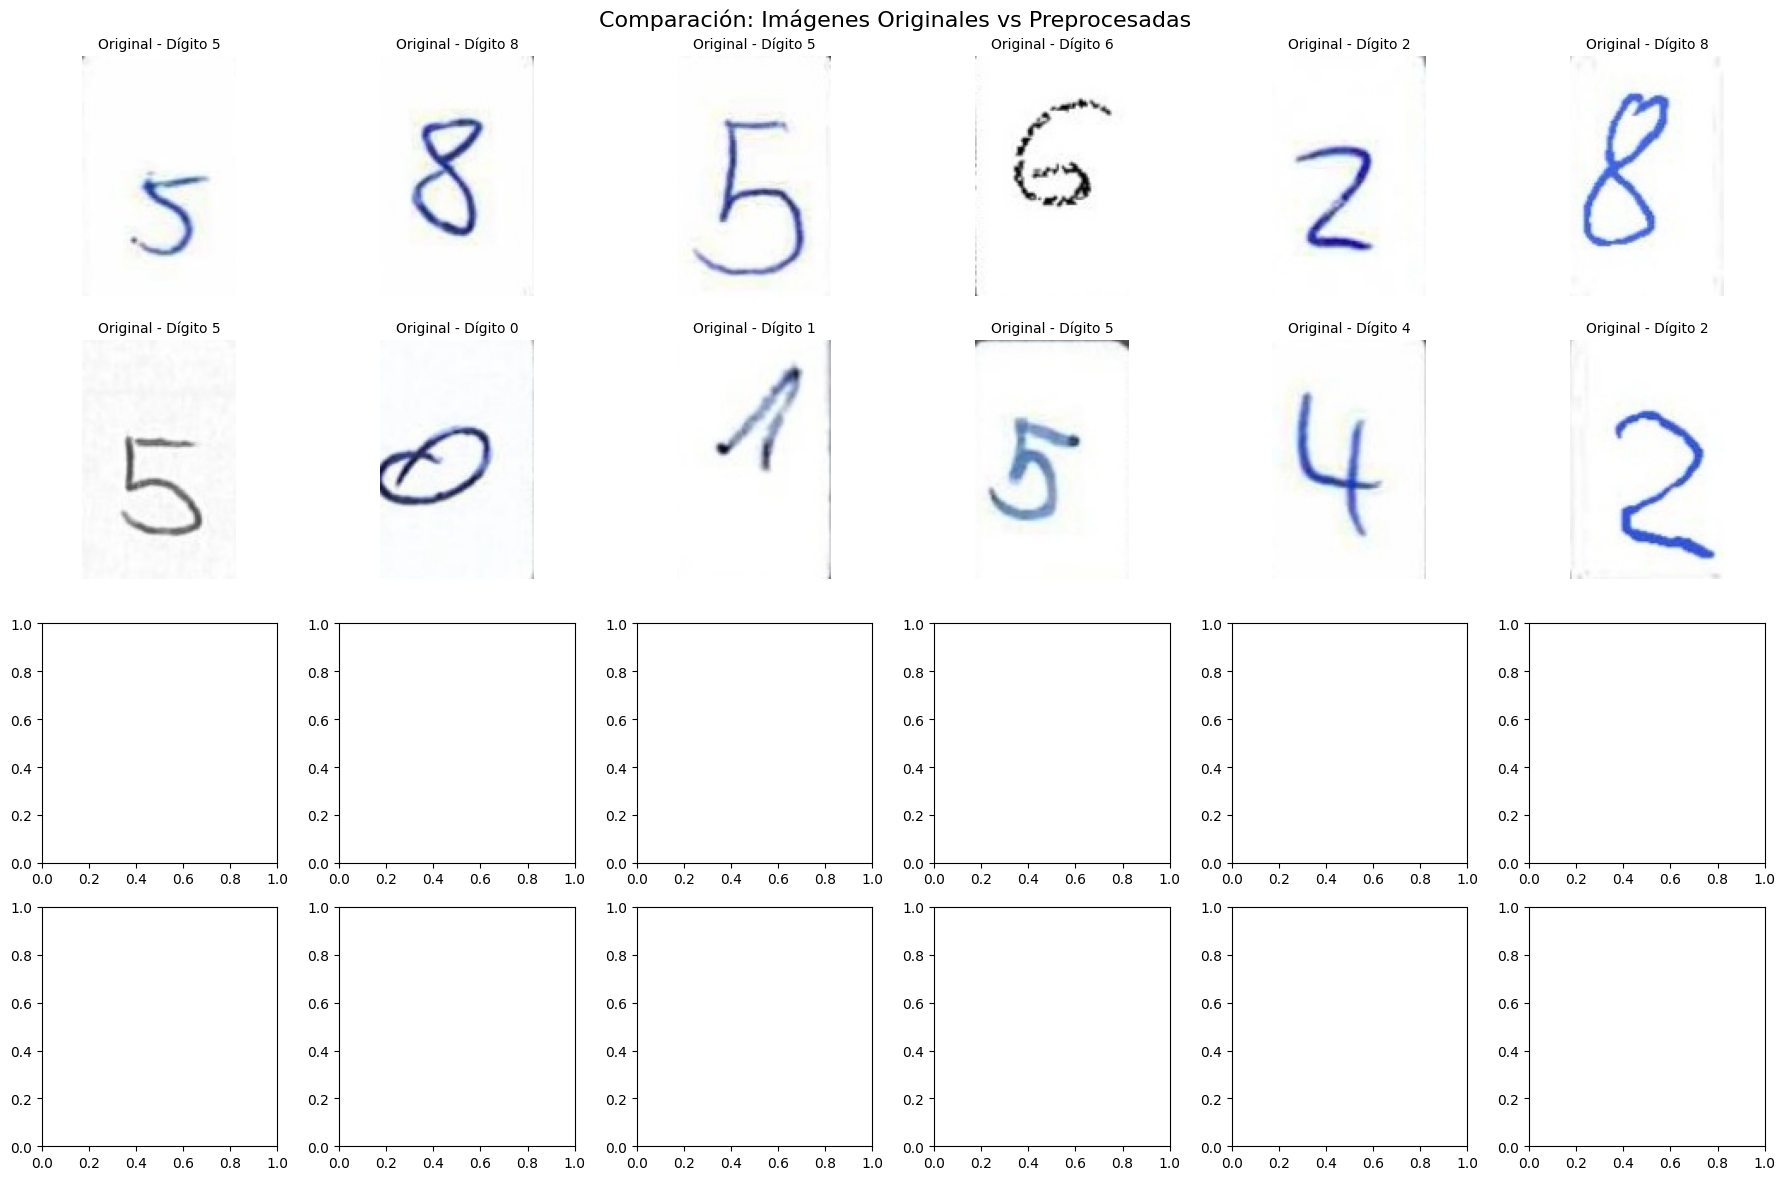

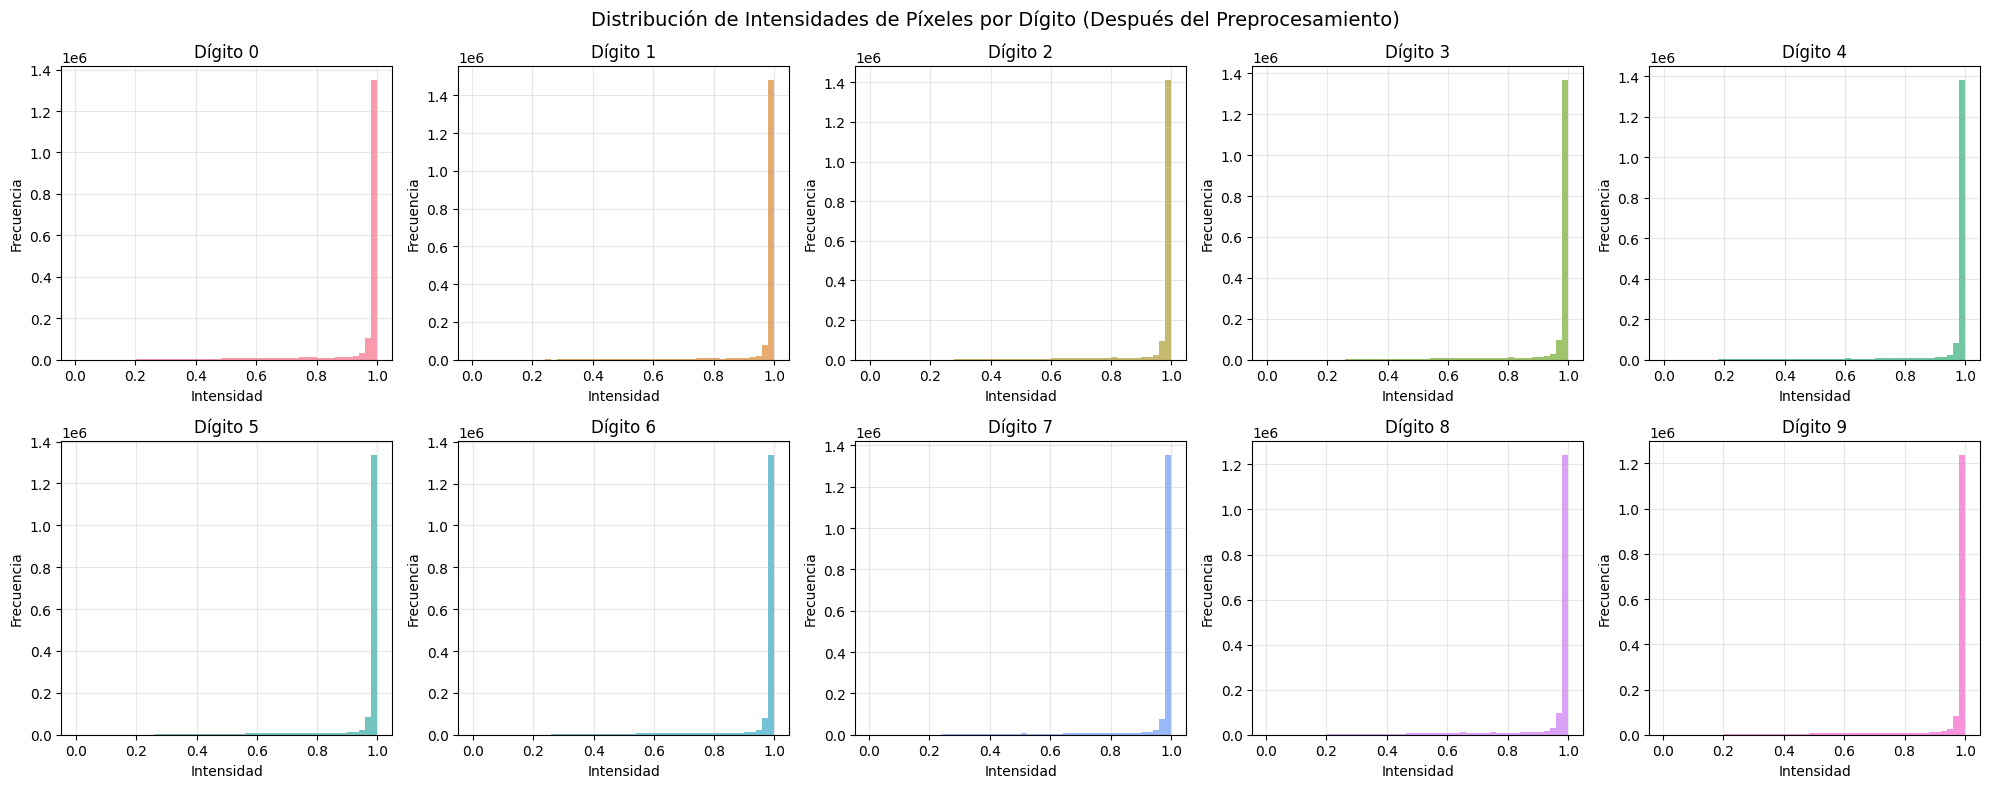

In [34]:
# Mostrar ejemplos antes y después del preprocesamiento
fig, axes = plt.subplots(4, 6, figsize=(18, 12))
fig.suptitle('Comparación: Imágenes Originales vs Preprocesadas', fontsize=16)

sample_indices = np.random.choice(len(X_processed), 12, replace=False)

for i, idx in enumerate(sample_indices[:12]):
    row = i // 6
    col = i % 6

    if row < 2:  # Primeras dos filas: originales
        # Cargar imagen original para comparación
        digit = y_processed[idx]
        digit_path = os.path.join(DATA_PATH, str(digit))
        image_files = [f for f in os.listdir(digit_path) if f.endswith('.jpg')]

        # Tomar una imagen aleatoria de esa clase
        random_file = np.random.choice(image_files)
        image_path = os.path.join(digit_path, random_file)
        original = cv2.imread(image_path)
        original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

        axes[row, col].imshow(original_rgb)
        axes[row, col].set_title(f'Original - Dígito {digit}', fontsize=10)
    else:  # Últimas dos filas: preprocesadas
        axes[row, col].imshow(X_processed[idx], cmap='gray')
        axes[row, col].set_title(f'Preprocesada - Dígito {y_processed[idx]}', fontsize=10)

    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Análisis de la distribución de píxeles después del preprocesamiento
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Distribución de Intensidades de Píxeles por Dígito (Después del Preprocesamiento)', fontsize=14)

for digit in range(10):
    row = digit // 5
    col = digit % 5

    # Obtener todas las imágenes de este dígito
    digit_images = X_processed[y_processed == digit]

    # Calcular histograma de intensidades
    all_pixels = digit_images.flatten()

    axes[row, col].hist(all_pixels, bins=50, alpha=0.7, color=sns.color_palette("husl", 10)[digit])
    axes[row, col].set_title(f'Dígito {digit}')
    axes[row, col].set_xlabel('Intensidad')
    axes[row, col].set_ylabel('Frecuencia')
    axes[row, col].grid(alpha=0.3)

plt.tight_layout()
plt.show()


---

## 5. Implementación y Experimentación de Modelos



### 5.1 Regresión Multivariada (Regresión Logística)
*[Implementación y ajuste de parámetros]*

### 5.2 Árboles de Decisión
*[Implementación y GridSearchCV]*

### 5.3 Random Forest
*[Implementación y optimización]*

### 5.4 Redes Neuronales
*[Implementación y ajuste de hiperparámetros]*

---

## 6. Evaluación y Comparación de Modelos

### 6.1 Métricas de Evaluación
- Accuracy
- Precision, Recall, F1-score
- Matrices de confusión
- Análisis por clase (especialmente dígitos 1 y 7)

### 6.2 Comparación de Resultados
*[Tabla comparativa y análisis detallado]*

---

## 7. Análisis de Resultados

### 7.1 Interpretación de Métricas
*[Análisis detallado del desempeño por modelo]*

### 7.2 Análisis de Errores
*[Casos donde los modelos fallan, especialmente confusión 1-7]*

---

## 8. Conclusiones

### 8.1 Resumen de Resultados
*[Mejor modelo y justificación]*

### 8.2 Limitaciones del Estudio
*[Identificación de limitaciones]*

### 8.3 Trabajo Futuro
*[Propuestas para mejorar los resultados]*
- Técnicas de data augmentation
- Modelos de deep learning más avanzados
- Preprocesamiento específico para bordes negros
- Análisis más profundo de diferencias europeas vs americanas

---

## Referencias
[1] Deng, L. (2012). The mnist database of handwritten digit images for machine learning research. IEEE Signal Processing Magazine, 29(6), 141–142.

[2] André Meier. (2022). Handwritten Digits 0 - 9 [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/4632848